In [ ]:
# Google Colab cần cài PyPortfolioOpt nếu chưa có
!pip install PyPortfolioOpt

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns, risk_models
from pypfopt.risk_models import sample_cov
from pypfopt import plotting
from pypfopt.objective_functions import L2_reg

import warnings
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 9.8 MB/s eta 0:00:00


In [ ]:
# BƯỚC 3: Đọc dữ liệu từ file CSV
path = r"/content/Data_of_price(1_year).csv"  # đổi đường dẫn đúng với bạn
df = pd.read_csv(path)



(390, 3)


<Figure size 1000x600 with 0 Axes>

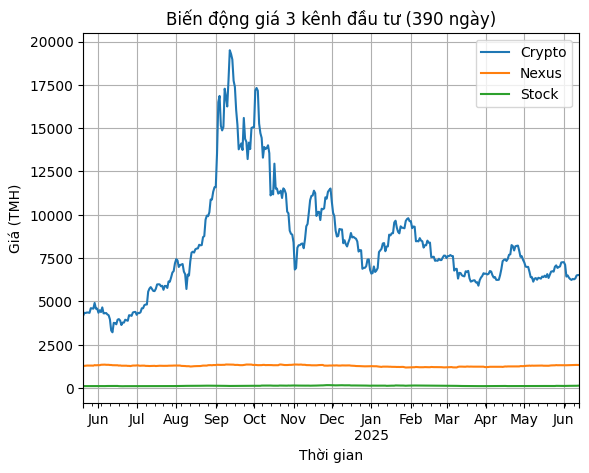

In [ ]:
# Giả sử bạn đã upload file CSV chứa 390 ngày dữ liệu lên Colab
#from google.colab import files
#uploaded = files.upload()

# Đọc dữ liệu
#df = pd.read_csv(next(iter(uploaded)))

# Đổi tên cột cho rõ ràng nếu cần
df.columns = ['Time', 'Crypto', 'Nexus_Buy', 'Nexus_Sell', 'Stock']

# Chọn giá đại diện để tính lợi nhuận
df['Nexus'] = df['Nexus_Sell']

df = df[['Time', 'Crypto', 'Nexus', 'Stock']]

# Chuyển định dạng ngày tháng nếu cần
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)
df = df.fillna(method='ffill')    # Forward fill
print(df.shape)
# Giữ lại các cột cần thiết
#asset_prices = df[['Crypto', 'Nexus', 'Stock']]
# Biểu đồ giá
plt.figure(figsize=(10, 6))
df.plot()
plt.title("Biến động giá 3 kênh đầu tư (390 ngày)")
plt.xlabel("Thời gian")
plt.ylabel("Giá (TMH)")
plt.grid(True)
plt.show()

In [ ]:
# Lợi suất logarit hàng ngày
# returns = np.log(asset_prices / asset_prices.shift(1)).dropna()
returns = np.log(df / df.shift(1)).dropna()
# returns = df.pct_change().dropna()
returns['Saving'] = np.log(1 + 0.075)/365 # log return của lãi suất ngân hàng
print(returns)

mu = expected_returns.mean_historical_return(df, frequency=returns.shape[0], compounding=True)
S = risk_models.sample_cov(df, returns_data=False, frequency=returns.shape[0], log_returns=True)

# Thêm kênh tiết kiệm với lợi suất cố định 7.5%
mu['Saving'] = 0.075
S.loc['Saving'] = 0
S['Saving'] = 0
S.loc['Saving', 'Saving'] = 1e-10  # tránh ma trận suy biến

# In lợi suất kỳ vọng
print("Lợi suất kỳ vọng các kênh đầu tư:")
print(mu.round(5))

              Crypto     Nexus     Stock    Saving
Time                                              
2024-05-21  0.038845  0.004031  0.013178  0.000198
2024-05-22 -0.001971  0.007936 -0.040003  0.000198
2024-05-23  0.006614  0.007226  0.004229  0.000198
2024-05-24 -0.001424  0.000239 -0.012736  0.000198
2024-05-25 -0.003510  0.000000  0.000000  0.000198
...              ...       ...       ...       ...
2025-06-09 -0.003689  0.007073  0.030113  0.000198
2025-06-10  0.008398 -0.003906 -0.015309  0.000198
2025-06-11  0.026983  0.001606  0.009929  0.000198
2025-06-12  0.003010 -0.003877  0.038140  0.000198
2025-06-13  0.000573 -0.001205  0.027408  0.000198

[389 rows x 4 columns]
Lợi suất kỳ vọng các kênh đầu tư:
Crypto    0.56227
Nexus     0.04258
Stock     0.22145
Saving    0.07500
dtype: float64


In [ ]:
# TỐI ƯU DANH MỤC ĐẦU TƯ

risk_free_rate = 0.05

def print_result(title, ef):
    print(f"\n🔹 {title}")
    weights = ef.clean_weights()
    for asset, w in weights.items():
        print(f"{asset}: {round(w * 100, 2)}%")
    perf = ef.portfolio_performance(verbose=False, risk_free_rate=risk_free_rate)

    w_opt = np.array(list(weights.values()))
    expected_return =  (w_opt @ mu)
    volatility = np.sqrt(w_opt @ S @ w_opt)
    sharpe = (expected_return - risk_free_rate) / volatility

    print(f"Expected anual return: {expected_return*100:.2f}% ")
    print(f"Anual votality: {volatility * 100:.2f}%")
    print(f"Sharpe: {sharpe:.2f}")

    return weights, perf

# --- 1. Danh mục có rủi ro thấp nhất (min volatility)
ef_min_vol = EfficientFrontier(mu, S)
ef_min_vol.add_constraint(lambda w: w >= 0)
ef_min_vol.min_volatility()
weights_min_vol, perf_min_vol = print_result("Min Volatility Portfolio", ef_min_vol)

# --- 2. Danh mục giới hạn rủi ro ở mức 15% (efficient risk)
target_vol = 0.15
ef_risk_constrained = EfficientFrontier(mu, S)
ef_risk_constrained.add_constraint(lambda w: w >= 0)
ef_risk_constrained.efficient_risk(target_volatility=target_vol)
weights_risk_constrained, perf_risk_constrained = print_result(f"Efficient Portfolio (≤ {int(target_vol*100)}% Volatility)", ef_risk_constrained)

# --- 3. Danh mục tối đa hóa Sharpe (chỉ để tham khảo nếu rủi ro cao)
ef_max_sharpe = EfficientFrontier(mu, S)
ef_max_sharpe.add_constraint(lambda w: w >= 0)
ef_max_sharpe.max_sharpe(risk_free_rate=risk_free_rate)
weights_max_sharpe, perf_max_sharpe = print_result("Max Sharpe Ratio Portfolio", ef_max_sharpe)

# --- 4. Tối đa hóa quadratic
ef_quadratic = EfficientFrontier(mu, S)
ef_quadratic.max_quadratic_utility(risk_aversion=20)
weights_quadratic, perf_max_sharpe = print_result("Quadratic Portfolio", ef_quadratic)

# ---- 5. Quadratic + bayesian
T, n = returns.shape[0], 4

# Prior
mu0 = np.zeros(n)
kappa0 = 0.01
nu0 = n + 2
psi0 = np.eye(n) * 0.001

# Tính hậu nghiệm
x_bar = returns.mean(axis=0)
s = np.cov(returns.T, bias=False)
assets = ['Crypto', 'Nexus', 'Stock', 'Saving']
s = pd.DataFrame(s, index=assets, columns=assets)

kappa_n = kappa0 + T
mu_n = 252 * (kappa0 * mu0 + T * x_bar) / kappa_n

nu_n = nu0 + T
psi_n = psi0 + s * T + (kappa0 * T) / (kappa0 + T) * np.outer((x_bar - mu0), (x_bar - mu0))

# Ước lượng posterior mean cho Sigma là kỳ vọng của IW
Sigma_post = 252 * psi_n / (nu_n - n - 1)

ef_bayes = EfficientFrontier(mu_n, Sigma_post)
ef_bayes.max_quadratic_utility(risk_aversion=20)
weights_bayes, perf_bayes = print_result("Bayesian Portfolio", ef_bayes)

#


🔹 Min Volatility Portfolio
Crypto: 0.0%
Nexus: 0.0%
Stock: 0.0%
Saving: 100.0%
Expected anual return: 7.50% 
Anual votality: 0.00%
Sharpe: 2500.00

🔹 Efficient Portfolio (≤ 15% Volatility)
Crypto: 12.68%
Nexus: 0.0%
Stock: 20.73%
Saving: 66.59%
Expected anual return: 16.72% 
Anual votality: 15.00%
Sharpe: 0.78

🔹 Max Sharpe Ratio Portfolio
Crypto: 0.0%
Nexus: 0.0%
Stock: 0.0%
Saving: 100.0%
Expected anual return: 7.50% 
Anual votality: 0.00%
Sharpe: 2499.95

🔹 Quadratic Portfolio
Crypto: 2.6%
Nexus: 0.0%
Stock: 4.25%
Saving: 93.16%
Expected anual return: 9.39% 
Anual votality: 3.07%
Sharpe: 1.43

🔹 Bayesian Portfolio
Crypto: 2.07%
Nexus: 0.0%
Stock: 4.11%
Saving: 93.82%
Expected anual return: 9.11% 
Anual votality: 2.63%
Sharpe: 1.56


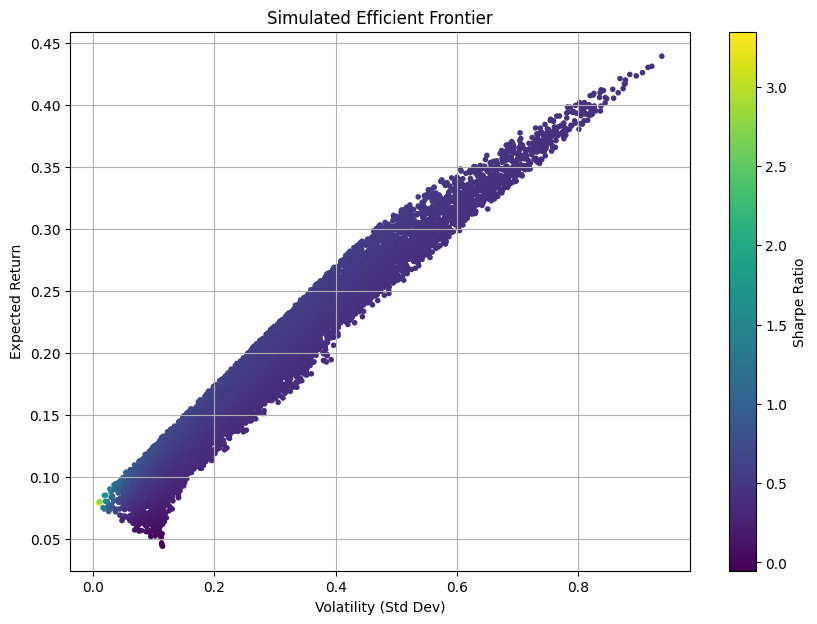

In [ ]:
# Tự dựng đường biên từ returns và weights ngẫu nhiên
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(len(returns.columns)), size=1)[0]
    weights_record.append(weights)
    portfolio_return = np.dot(weights, returns.mean()) * 390
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 390, weights)))
    results[0,i] = portfolio_return
    results[1,i] = portfolio_stddev
    results[2,i] = (portfolio_return - risk_free_rate) / portfolio_stddev

# Vẽ bằng matplotlib
plt.figure(figsize=(10,7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='.')
plt.xlabel('Volatility (Std Dev)')
plt.ylabel('Expected Return')
plt.title('Simulated Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()


In [ ]:
#Cả hai danh mục đều phân bổ 100% vào Saving
#(tức là chỉ đầu tư vào ngân hàng có lãi suất 7.5%), nghĩa
#Expected return = 7.5%      Volatility = 0%
#Min Volatility Portfolio và Max Sharpe Ratio Portfolio theo công thức sẽ rất lớn
#Kết quả sẽ cho bạn Sharpe cực cao, đúng bản chất là “tỷ suất lợi nhuận cao hơn rủi ro gần như bằng 0”.

expected_return = 0.075
risk_free_rate = 0.05
volatility = 1e-8  # Giả sử nhỏ gần bằng 0

sharpe = (expected_return - risk_free_rate) / volatility
print("Sharpe:", sharpe)


Sharpe: 2499999.9999999995


**Yêu** **cầu** **2**

In [ ]:
# === Phần mở rộng cho YÊU CẦU 2 ===
# Kiểm thử tính bền vững của danh mục khi điều kiện thay đổi
from copy import deepcopy



def run_scenario(title, df_original, mu_original, S_original, mu_n_original, Sigma_post_original ,scenario_func):
    print("\n===========================")
    print(f"Kịch bản: {title}")
    print("===========================")

    # Deep copy dữ liệu gốc
    df_scenario = deepcopy(df_original)
    mu_scenario = deepcopy(mu_original)
    S_scenario = deepcopy(S_original)
    mu_n_scenario = deepcopy(mu_n_original)
    Sigma_post_scenario = deepcopy(Sigma_post_original)

    # Áp dụng thay đổi
    df_scenario, mu_scenario, S_scenario = scenario_func(df_scenario, mu_scenario, S_scenario)

    # Đánh giá lại danh mục sau thay đổi
    def run_case(title, ef):
        print(f"\n🔹 {title}")
        weights = ef.clean_weights()
        for asset, w in weights.items():
            print(f"{asset}: {round(w * 100, 2)}%")
        ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

    ef1 = EfficientFrontier(mu_scenario, S_scenario)
    ef1.add_constraint(lambda w: w >= 0)
    ef1.min_volatility()
    run_case("Min Volatility Portfolio", ef1)

    ef2 = EfficientFrontier(mu_scenario, S_scenario)
    ef2.add_constraint(lambda w: w >= 0)
    ef2.efficient_risk(target_volatility=target_vol)
    run_case(f"Efficient Portfolio (≤ {int(target_vol*100)}% Volatility)", ef2)

    ef3 = EfficientFrontier(mu_scenario, S_scenario)
    ef3.add_constraint(lambda w: w >= 0)
    ef3.max_sharpe(risk_free_rate=risk_free_rate)
    run_case("Max Sharpe Ratio Portfolio", ef3)

    ef4 = EfficientFrontier(mu_scenario, S_scenario)
    ef4.add_constraint(lambda w: w >= 0)
    ef4.max_quadratic_utility(risk_aversion=20)
    run_case("Quadratic Portfolio", ef4)

    ef5 = EfficientFrontier(mu_n_scenario, Sigma_post_scenario)
    ef5.add_constraint(lambda w: w >= 0)
    ef5.max_quadratic_utility(risk_aversion=20)
    run_case("Bayesian Portfolio", ef5)



# === Kịch bản 1: Crypto giảm giá 20% trong năm ===
def scenario_crypto_down(df, mu, S):
    mu['Crypto'] *= 0.8
    return df, mu, S

# === Kịch bản 2: Lãi suất tiết kiệm giảm 2% ===
def scenario_interest_down(df, mu, S):
    mu['Saving'] -= 0.02
    return df, mu, S

# === Kịch bản 3: Nexus biến động gấp đôi (tăng rủi ro) ===
def scenario_nexus_volatility(df, mu, S):
    S.loc['Nexus'] *= 2
    S['Nexus'] *= 2
    return df, mu, S

# === Thực thi ===
run_scenario("Giá Crypto giảm 20%", df, mu, S, mu_n, Sigma_post, scenario_crypto_down)
run_scenario("Lãi suất tiết kiệm giảm 2%", df, mu, S, mu_n, Sigma_post, scenario_crypto_down)
run_scenario("Rủi ro Nexus tăng cao", df, mu, S, mu_n, Sigma_post, scenario_crypto_down)



Kịch bản: Giá Crypto giảm 20%

🔹 Min Volatility Portfolio
Crypto: 0.0%
Nexus: 0.0%
Stock: 0.0%
Saving: 100.0%
Expected annual return: 7.5%
Annual volatility: 0.0%
Sharpe Ratio: 2500.00

🔹 Efficient Portfolio (≤ 15% Volatility)
Crypto: 11.41%
Nexus: 0.0%
Stock: 24.45%
Saving: 64.14%
Expected annual return: 15.4%
Annual volatility: 15.0%
Sharpe Ratio: 0.69

🔹 Max Sharpe Ratio Portfolio
Crypto: 0.0%
Nexus: 0.0%
Stock: 0.0%
Saving: 100.0%
Expected annual return: 7.5%
Annual volatility: 0.0%
Sharpe Ratio: 2499.53

🔹 Quadratic Portfolio
Crypto: 1.99%
Nexus: 0.0%
Stock: 4.27%
Saving: 93.74%
Expected annual return: 8.9%
Annual volatility: 2.6%
Sharpe Ratio: 1.48

🔹 Bayesian Portfolio
Crypto: 2.07%
Nexus: 0.0%
Stock: 4.11%
Saving: 93.82%
Expected annual return: 5.8%
Annual volatility: 3.2%
Sharpe Ratio: 0.26

Kịch bản: Lãi suất tiết kiệm giảm 2%

🔹 Min Volatility Portfolio
Crypto: 0.0%
Nexus: 0.0%
Stock: 0.0%
Saving: 100.0%
Expected annual return: 7.5%
Annual volatility: 0.0%
Sharpe Ratio: 250

yêu cầu 2 (thêm 3 kịch bản khác nữa)

In [ ]:
#=== Kịch bản 4: Biến động của Stock tăng gấp đôi (thị trường bất ổn) ===
print("\n" + "="*27)
print("Kịch bản: Biến động Stock tăng gấp đôi")
print("="*27)

# Copy dữ liệu gốc
df_scenario = df.copy()
returns_scenario = returns.copy()

# Tăng phương sai (rủi ro) của Stock lên 4x (gấp đôi độ lệch chuẩn)
S_mod = S.copy()
S_mod.loc['Stock', 'Stock'] *= 4

Sigma_post_mod = Sigma_post.copy()
Sigma_post_mod.loc['Stock', 'Stock'] *= 4

# Tối ưu lại
ef_min_vol = EfficientFrontier(mu, S_mod)
ef_min_vol.add_constraint(lambda w: w >= 0)
ef_min_vol.min_volatility()
print_result("Min Volatility Portfolio", ef_min_vol)

ef_risk = EfficientFrontier(mu, S_mod)
ef_risk.add_constraint(lambda w: w >= 0)
ef_risk.efficient_risk(target_volatility=target_vol)
print_result(f"Efficient Portfolio (≤ {int(target_vol*100)}% Volatility)", ef_risk)

ef_max_sharpe = EfficientFrontier(mu, S_mod)
ef_max_sharpe.add_constraint(lambda w: w >= 0)
ef_max_sharpe.max_sharpe(risk_free_rate=risk_free_rate)
print_result("Max Sharpe Ratio Portfolio", ef_max_sharpe)

ef_quadratic = EfficientFrontier(mu, S_mod)
ef_quadratic.max_quadratic_utility(risk_aversion=20)
print_result("Quadratic Portfolio", ef_quadratic)

ef_bayes = EfficientFrontier(mu_n, Sigma_post_mod)
ef_bayes.max_quadratic_utility(risk_aversion=20)
print_result("Bayesian Portfolio", ef_bayes)



Kịch bản: Biến động Stock tăng gấp đôi

🔹 Min Volatility Portfolio
Crypto: 0.0%
Nexus: 0.0%
Stock: 0.0%
Saving: 100.0%
Expected anual return: 7.50% 
Anual votality: 0.00%
Sharpe: 2500.00

🔹 Efficient Portfolio (≤ 15% Volatility)
Crypto: 14.69%
Nexus: 0.0%
Stock: 5.95%
Saving: 79.36%
Expected anual return: 15.53% 
Anual votality: 14.39%
Sharpe: 0.73

🔹 Max Sharpe Ratio Portfolio
Crypto: 0.0%
Nexus: 0.0%
Stock: 0.0%
Saving: 100.0%
Expected anual return: 7.50% 
Anual votality: 0.00%
Sharpe: 2500.00

🔹 Quadratic Portfolio
Crypto: 2.62%
Nexus: 0.0%
Stock: 1.06%
Saving: 96.32%
Expected anual return: 8.93% 
Anual votality: 2.57%
Sharpe: 1.53

🔹 Bayesian Portfolio
Crypto: 2.09%
Nexus: 0.0%
Stock: 1.03%
Saving: 96.88%
Expected anual return: 8.67% 
Anual votality: 2.06%
Sharpe: 1.78


(OrderedDict([('Crypto', 0.0209),
              ('Nexus', 0.0),
              ('Stock', 0.01032),
              ('Saving', 0.96878)]),
 (np.float64(0.055748732194519084),
  np.float64(0.030280890714868024),
  np.float64(0.18984686575604703)))

In [ ]:
# kịch bản 5
print("\n" + "="*27)
print("Kịch bản: Lãi suất Saving tăng lên 9%")
print("="*27)

mu_mod = mu.copy()
mu_mod['Saving'] = 0.09  # tăng từ 7.5% lên 9%

mu_n_mode = mu_n.copy()
mu_n_mode['Saving'] = 0.09
# Tối ưu lại
ef_min_vol = EfficientFrontier(mu_mod, S)
ef_min_vol.add_constraint(lambda w: w >= 0)
ef_min_vol.min_volatility()
print_result("Min Volatility Portfolio", ef_min_vol)

ef_risk = EfficientFrontier(mu_mod, S)
ef_risk.add_constraint(lambda w: w >= 0)
ef_risk.efficient_risk(target_volatility=target_vol)
print_result(f"Efficient Portfolio (≤ {int(target_vol*100)}% Volatility)", ef_risk)

ef_max_sharpe = EfficientFrontier(mu_mod, S)
ef_max_sharpe.add_constraint(lambda w: w >= 0)
ef_max_sharpe.max_sharpe(risk_free_rate=risk_free_rate)
print_result("Max Sharpe Ratio Portfolio", ef_max_sharpe)

ef_quadratic = EfficientFrontier(mu_mod, S)
ef_quadratic.max_quadratic_utility(risk_aversion=20)
print_result("Quadratic Portfolio", ef_quadratic)

ef_bayes = EfficientFrontier(mu_n_mode, Sigma_post)
ef_bayes.max_quadratic_utility(risk_aversion=20)
print_result("Bayesian Portfolio", ef_bayes)



Kịch bản: Lãi suất Saving tăng lên 9%

🔹 Min Volatility Portfolio
Crypto: 0.0%
Nexus: 0.0%
Stock: 0.0%
Saving: 100.0%
Expected anual return: 7.50% 
Anual votality: 0.00%
Sharpe: 2500.00

🔹 Efficient Portfolio (≤ 15% Volatility)
Crypto: 15.24%
Nexus: 0.0%
Stock: 2.4%
Saving: 82.36%
Expected anual return: 15.28% 
Anual votality: 15.00%
Sharpe: 0.69

🔹 Max Sharpe Ratio Portfolio
Crypto: 0.0%
Nexus: 0.0%
Stock: 0.0%
Saving: 100.0%
Expected anual return: 7.50% 
Anual votality: 0.00%
Sharpe: 2499.90

🔹 Quadratic Portfolio
Crypto: 2.54%
Nexus: 0.0%
Stock: 0.4%
Saving: 97.06%
Expected anual return: 8.80% 
Anual votality: 2.50%
Sharpe: 1.52

🔹 Bayesian Portfolio
Crypto: 1.76%
Nexus: 0.0%
Stock: 0.25%
Saving: 97.99%
Expected anual return: 8.40% 
Anual votality: 1.73%
Sharpe: 1.97


(OrderedDict([('Crypto', 0.01763),
              ('Nexus', 0.0),
              ('Stock', 0.00246),
              ('Saving', 0.97991)]),
 (np.float64(0.09360649142837858),
  np.float64(0.028521887170222582),
  np.float64(1.5288781968783827)))

In [ ]:
#kịch bản 6
print("\n" + "="*27)
print("Kịch bản: Tương quan Crypto - Stock tăng cao")
print("="*27)

S_mod = S.copy()

# Tăng tương quan bằng cách điều chỉnh hiệp phương sai
cov_cs = S_mod.loc['Crypto', 'Stock']
avg_std = np.sqrt(S_mod.loc['Crypto', 'Crypto'] * S_mod.loc['Stock', 'Stock'])
new_cov = 0.9 * avg_std  # giả định tương quan 0.9
S_mod.loc['Crypto', 'Stock'] = new_cov
S_mod.loc['Stock', 'Crypto'] = new_cov


Sigma_post_mod = Sigma_post.copy()
cov_cs = Sigma_post_mod.loc['Crypto', 'Stock']
avg_std = np.sqrt(Sigma_post_mod.loc['Crypto', 'Crypto'] * Sigma_post_mod.loc['Stock', 'Stock'])
new_cov = 0.9 * avg_std  # giả định tương quan 0.9
Sigma_post_mod.loc['Crypto', 'Stock'] = new_cov
Sigma_post_mod.loc['Stock', 'Crypto'] = new_cov


# Tối ưu lại
ef_min_vol = EfficientFrontier(mu, S_mod)
ef_min_vol.add_constraint(lambda w: w >= 0)
ef_min_vol.min_volatility()
print_result("Min Volatility Portfolio", ef_min_vol)

ef_risk = EfficientFrontier(mu, S_mod)
ef_risk.add_constraint(lambda w: w >= 0)
ef_risk.efficient_risk(target_volatility=target_vol)
print_result(f"Efficient Portfolio (≤ {int(target_vol*100)}% Volatility)", ef_risk)

ef_max_sharpe = EfficientFrontier(mu, S_mod)
ef_max_sharpe.add_constraint(lambda w: w >= 0)
ef_max_sharpe.max_sharpe(risk_free_rate=risk_free_rate)
print_result("Max Sharpe Ratio Portfolio", ef_max_sharpe)

ef_quadratic = EfficientFrontier(mu, S_mod)
ef_quadratic.max_quadratic_utility(risk_aversion=20)
print_result("Quadratic Portfolio", ef_quadratic)

ef_bayes = EfficientFrontier(mu_n, Sigma_post_mod)
ef_bayes.max_quadratic_utility(risk_aversion=20)
print_result("Bayesian Portfolio", ef_bayes)


Kịch bản: Tương quan Crypto - Stock tăng cao

🔹 Min Volatility Portfolio
Crypto: 0.0%
Nexus: 0.0%
Stock: 0.0%
Saving: 100.0%
Expected anual return: 7.50% 
Anual votality: 0.00%
Sharpe: 2500.00

🔹 Efficient Portfolio (≤ 15% Volatility)
Crypto: 15.58%
Nexus: 0.0%
Stock: 0.0%
Saving: 84.42%
Expected anual return: 15.09% 
Anual votality: 15.00%
Sharpe: 0.67

🔹 Max Sharpe Ratio Portfolio
Crypto: 0.0%
Nexus: 0.0%
Stock: 0.0%
Saving: 100.0%
Expected anual return: 7.50% 
Anual votality: 0.00%
Sharpe: 2499.95

🔹 Quadratic Portfolio
Crypto: 2.63%
Nexus: 0.0%
Stock: 0.0%
Saving: 97.37%
Expected anual return: 8.78% 
Anual votality: 2.53%
Sharpe: 1.49

🔹 Bayesian Portfolio
Crypto: 2.1%
Nexus: 0.0%
Stock: 0.0%
Saving: 97.9%
Expected anual return: 8.52% 
Anual votality: 2.02%
Sharpe: 1.74


(OrderedDict([('Crypto', 0.02098),
              ('Nexus', 0.0),
              ('Stock', 0.0),
              ('Saving', 0.97902)]),
 (np.float64(0.05494646785404748),
  np.float64(0.02972261839328554),
  np.float64(0.1664209992739032)))

In [ ]:
# ===== Kịch bản: Nexus tăng trưởng mạnh, rủi ro giảm và ít tương quan với các tài sản khác =====
print("\n===========================")
print("Kịch bản: Nexus tăng trưởng mạnh, rủi ro giảm và ít tương quan với các tài sản khác")
print("===========================\n")

# Tăng lợi suất Nexus thêm 20%
mu_nexus = mu.copy()
mu_nexus['Nexus'] += 0.20

mu_n_nexus = mu_n.copy()
mu_n_nexus['Nexus'] += 0.20

# Giảm rủi ro Nexus còn 50%
S_nexus = S.copy()
S_nexus.loc['Nexus', 'Nexus'] *= 0.5

Sigma_post_nexus = Sigma_post.copy()
Sigma_post_nexus.loc['Nexus', 'Nexus'] *= 0.5

# Giảm tương quan Nexus với Crypto và Stock
corr_matrix = risk_models.cov_to_corr(S_nexus)
corr_matrix.loc['Nexus', 'Crypto'] = 0.05
corr_matrix.loc['Crypto', 'Nexus'] = 0.05
corr_matrix.loc['Nexus', 'Stock'] = 0.05
corr_matrix.loc['Stock', 'Nexus'] = 0.05

# Khôi phục lại ma trận hiệp phương sai từ corr matrix + standard deviations
stds = np.sqrt(np.diag(S_nexus))
S_nexus = pd.DataFrame(corr_matrix.values * np.outer(stds, stds), index=S.columns, columns=S.columns)

# Chạy mô hình
ef_nexus = EfficientFrontier(mu_nexus, S_nexus)
ef_nexus.add_constraint(lambda w: w >= 0)

# Min volatility
ef1 = EfficientFrontier(mu_nexus, S_nexus)
ef1.add_constraint(lambda w: w >= 0)
ef1.min_volatility()
print_result("Min Volatility Portfolio", ef1)

# Efficient risk
ef2 = EfficientFrontier(mu_nexus, S_nexus)
ef2.add_constraint(lambda w: w >= 0)
ef2.efficient_risk(target_volatility=0.15)
print_result("Efficient Portfolio (≤ 15% Volatility)", ef2)

# Max Sharpe
ef3 = EfficientFrontier(mu_nexus, S_nexus)
ef3.add_constraint(lambda w: w >= 0)
ef3.max_sharpe(risk_free_rate=risk_free_rate)
print_result("Max Sharpe Ratio Portfolio", ef3)

#Quadratic
ef4 = EfficientFrontier(mu_nexus, S_nexus)
ef4.max_quadratic_utility(risk_aversion=20)
print_result("Quadratic Portfolio", ef4)

#Bayes
ef5 = EfficientFrontier(mu_n_nexus, Sigma_post_nexus)
ef5.max_quadratic_utility(risk_aversion=20)
print_result("Bayesian Portfolio", ef5)



Kịch bản: Nexus tăng trưởng mạnh, rủi ro giảm và ít tương quan với các tài sản khác


🔹 Min Volatility Portfolio
Crypto: 0.0%
Nexus: 0.0%
Stock: 0.0%
Saving: 100.0%
Expected anual return: 7.50% 
Anual votality: 0.00%
Sharpe: 2500.00

🔹 Efficient Portfolio (≤ 15% Volatility)
Crypto: 9.76%
Nexus: 38.7%
Stock: 1.32%
Saving: 50.22%
Expected anual return: 11.20% 
Anual votality: 19.01%
Sharpe: 0.33

🔹 Max Sharpe Ratio Portfolio
Crypto: 0.0%
Nexus: 0.0%
Stock: 0.0%
Saving: 100.0%
Expected anual return: 7.50% 
Anual votality: 0.00%
Sharpe: 2500.00

🔹 Quadratic Portfolio
Crypto: 2.48%
Nexus: 9.83%
Stock: 0.34%
Saving: 87.35%
Expected anual return: 8.44% 
Anual votality: 4.83%
Sharpe: 0.71

🔹 Bayesian Portfolio
Crypto: 1.49%
Nexus: 17.16%
Stock: 0.1%
Saving: 81.25%
Expected anual return: 7.69% 
Anual votality: 7.18%
Sharpe: 0.37


(OrderedDict([('Crypto', 0.01492),
              ('Nexus', 0.17162),
              ('Stock', 0.001),
              ('Saving', 0.81246)]),
 (np.float64(0.0839661763180834),
  np.float64(0.047188967194580454),
  np.float64(0.7197906277123254)))

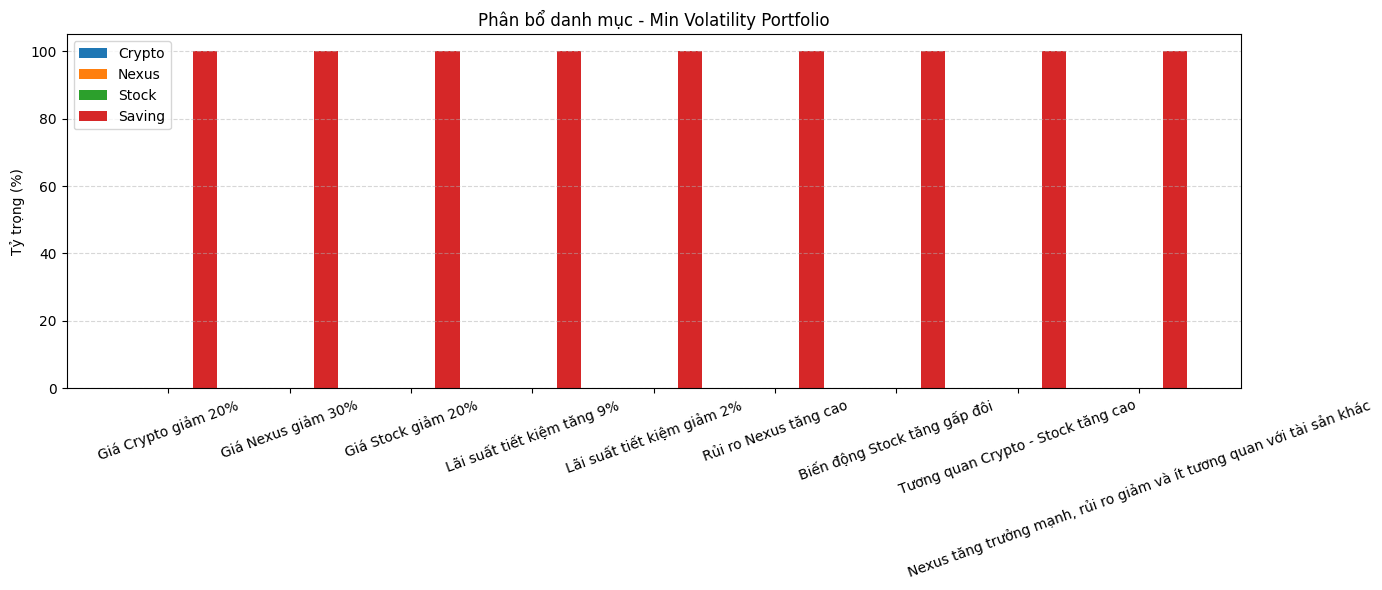

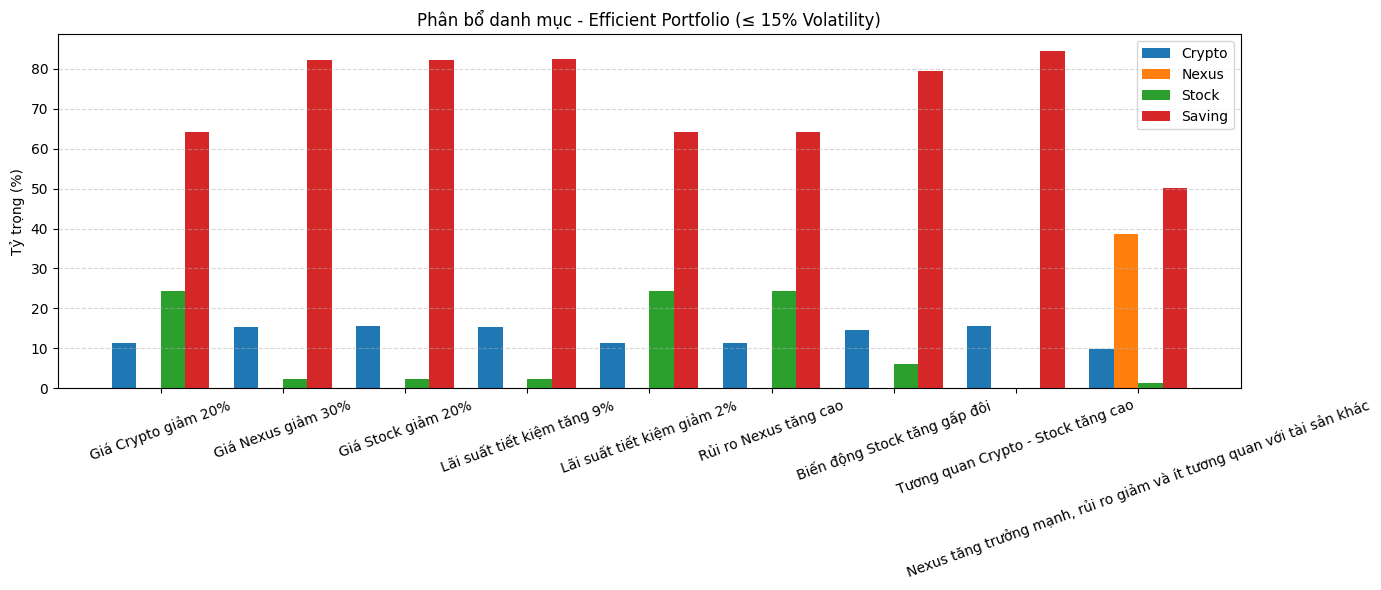

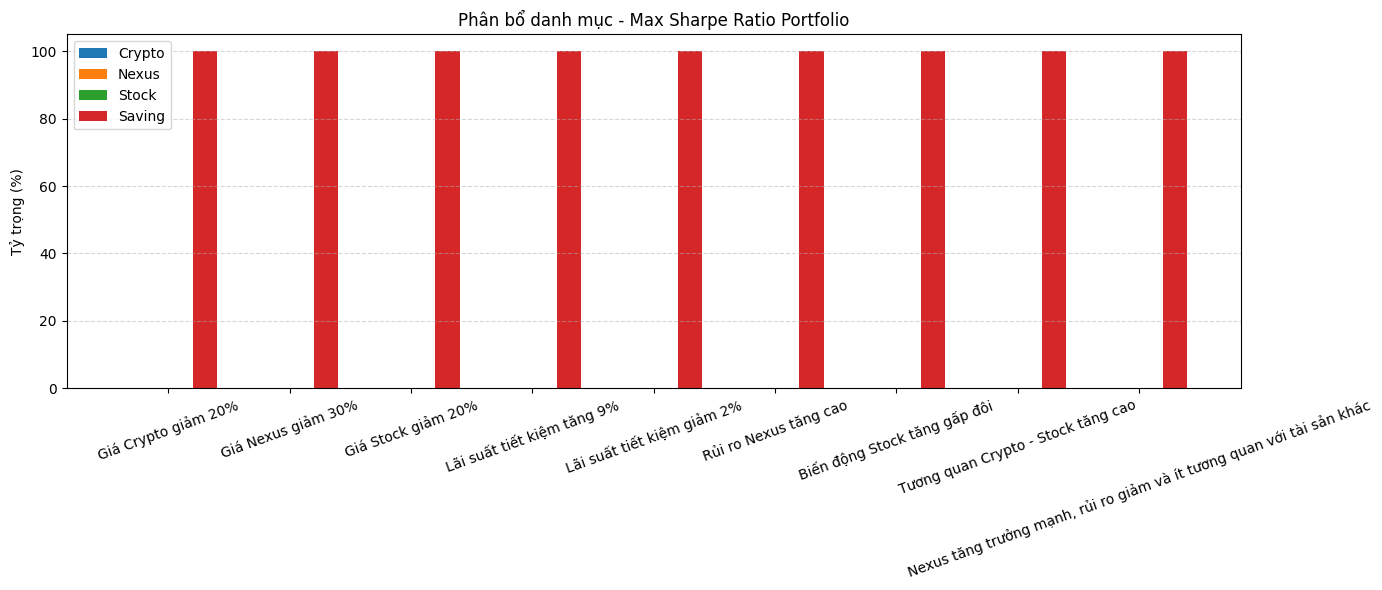

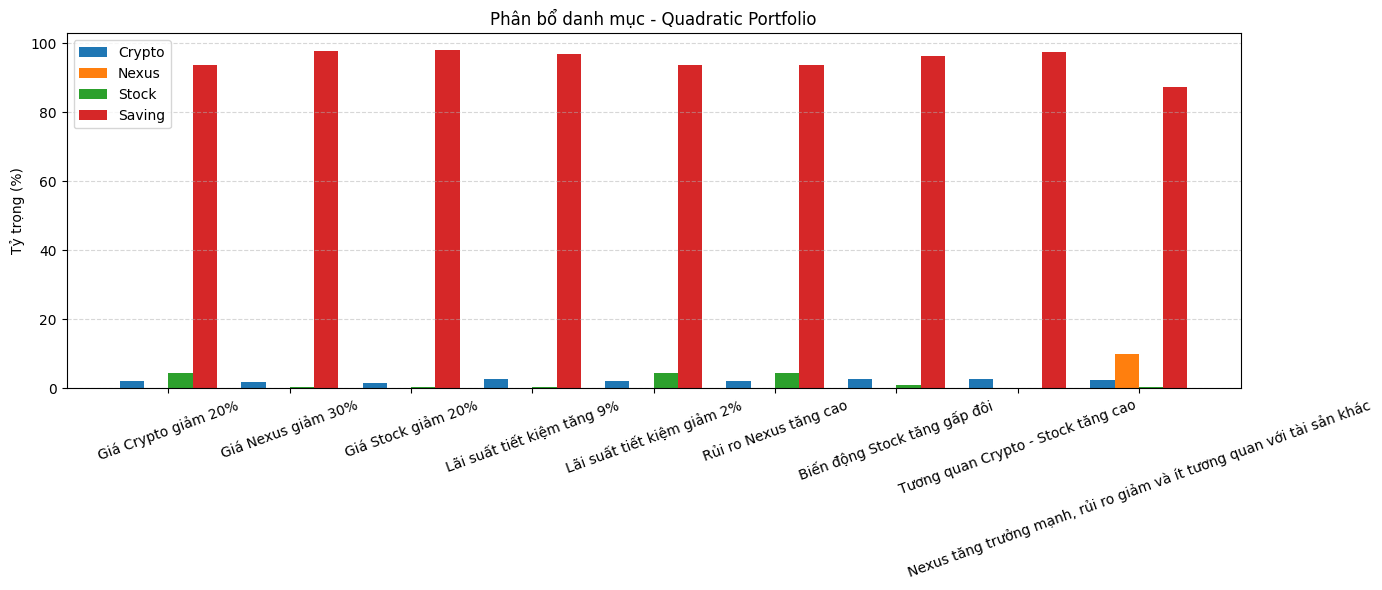

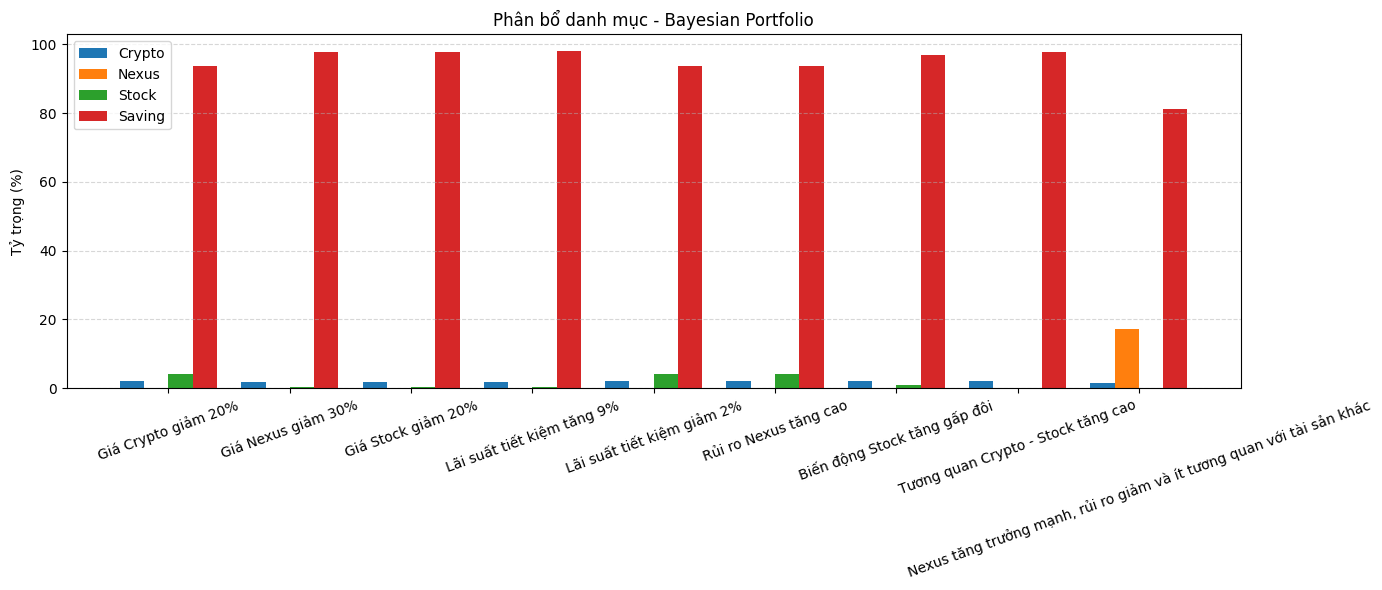

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Giả định: bạn đã có dict lưu kết quả phân bổ từ từng kịch bản
# Dưới đây là ví dụ mẫu bạn cần cập nhật tương ứng:

scenarios = {
    "Giá Crypto giảm 20%": {
        "Min Volatility Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Efficient Portfolio (≤ 15% Volatility)": {"Crypto": 0.1141, "Nexus": 0.0, "Stock": 0.2445, "Saving": 0.6414},
        "Max Sharpe Ratio Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Quadratic Portfolio": {"Crypto": 0.0199, "Nexus": 0.0, "Stock": 0.0427, "Saving": 0.9374},
        "Bayesian Portfolio": {"Crypto": 0.0207, "Nexus": 0.0, "Stock": 0.0411, "Saving": 0.9382},
    },
    "Giá Nexus giảm 30%": {
        "Min Volatility Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Efficient Portfolio (≤ 15% Volatility)": {"Crypto": 0.1523, "Nexus": 0.0, "Stock": 0.0243, "Saving": 0.8234},
        "Max Sharpe Ratio Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Quadratic Portfolio": {"Crypto": 0.0172, "Nexus": 0.0, "Stock": 0.0043, "Saving": 0.9785},
        "Bayesian Portfolio": {"Crypto": 0.0191, "Nexus": 0.0, "Stock": 0.0035, "Saving": 0.9774},
    },
    "Giá Stock giảm 20%": {
        "Min Volatility Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Efficient Portfolio (≤ 15% Volatility)": {"Crypto": 0.1551, "Nexus": 0.0, "Stock": 0.0231, "Saving": 0.8218},
        "Max Sharpe Ratio Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Quadratic Portfolio": {"Crypto": 0.0164, "Nexus": 0.0, "Stock": 0.0038, "Saving": 0.9798},
        "Bayesian Portfolio": {"Crypto": 0.0182, "Nexus": 0.0, "Stock": 0.0035, "Saving": 0.9783},
    },
    "Lãi suất tiết kiệm tăng 9%": {
        "Min Volatility Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Efficient Portfolio (≤ 15% Volatility)": {"Crypto": 0.1524, "Nexus": 0.0, "Stock": 0.0240, "Saving": 0.8236},
        "Max Sharpe Ratio Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Quadratic Portfolio": {"Crypto": 0.0254, "Nexus": 0.0, "Stock": 0.0040, "Saving": 0.9706},
        "Bayesian Portfolio": {"Crypto": 0.0176, "Nexus": 0.0, "Stock": 0.0025, "Saving": 0.9799},
    },
    "Lãi suất tiết kiệm giảm 2%": {
        "Min Volatility Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Efficient Portfolio (≤ 15% Volatility)": {"Crypto": 0.1141, "Nexus": 0.0, "Stock": 0.2445, "Saving": 0.6414},
        "Max Sharpe Ratio Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Quadratic Portfolio": {"Crypto": 0.0199, "Nexus": 0.0, "Stock": 0.0427, "Saving": 0.9374},
        "Bayesian Portfolio": {"Crypto": 0.0207, "Nexus": 0.0, "Stock": 0.0411, "Saving": 0.9382},
    },
    "Rủi ro Nexus tăng cao": {
        "Min Volatility Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Efficient Portfolio (≤ 15% Volatility)": {"Crypto": 0.1141, "Nexus": 0.0, "Stock": 0.2445, "Saving": 0.6414},
        "Max Sharpe Ratio Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Quadratic Portfolio": {"Crypto": 0.0199, "Nexus": 0.0, "Stock": 0.0427, "Saving": 0.9374},
        "Bayesian Portfolio": {"Crypto": 0.0207, "Nexus": 0.0, "Stock": 0.0411, "Saving": 0.9382},
    },
    "Biến động Stock tăng gấp đôi": {
        "Min Volatility Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Efficient Portfolio (≤ 15% Volatility)": {"Crypto": 0.1469, "Nexus": 0.0, "Stock": 0.0595, "Saving": 0.7936},
        "Max Sharpe Ratio Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Quadratic Portfolio": {"Crypto": 0.0262, "Nexus": 0.0, "Stock": 0.0106, "Saving": 0.9632},
        "Bayesian Portfolio": {"Crypto": 0.0209, "Nexus": 0.0, "Stock": 0.0103, "Saving": 0.9688},
    },
    "Tương quan Crypto - Stock tăng cao": {
        "Min Volatility Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Efficient Portfolio (≤ 15% Volatility)": {"Crypto": 0.1558, "Nexus": 0.0, "Stock": 0.0, "Saving": 0.8442},
        "Max Sharpe Ratio Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Quadratic Portfolio": {"Crypto": 0.0263, "Nexus": 0.0, "Stock": 0.0, "Saving": 0.9737},
        "Bayesian Portfolio": {"Crypto": 0.0210, "Nexus": 0.0, "Stock": 0.0, "Saving": 0.9790},
    },
    "Nexus tăng trưởng mạnh, rủi ro giảm và ít tương quan với tài sản khác": {
        "Min Volatility Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Efficient Portfolio (≤ 15% Volatility)": {"Crypto": 0.0976, "Nexus": 0.3870, "Stock": 0.0132, "Saving": 0.5022},
        "Max Sharpe Ratio Portfolio": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 1.0},
        "Quadratic Portfolio": {"Crypto": 0.0248, "Nexus": 0.0983, "Stock": 0.0034, "Saving": 0.8735},
        "Bayesian Portfolio": {"Crypto": 0.0149, "Nexus": 0.1716, "Stock": 0.0010, "Saving": 0.8125},
    },
}


portfolio_types = [
    "Min Volatility Portfolio",
    "Efficient Portfolio (≤ 15% Volatility)",
    "Max Sharpe Ratio Portfolio",
    "Quadratic Portfolio",
    "Bayesian Portfolio",
]

def plot_allocations(scenarios, portfolio_type):
    assets = ["Crypto", "Nexus", "Stock", "Saving"]
    labels = list(scenarios.keys())
    data = []

    for scen in labels:
        alloc = scenarios[scen][portfolio_type]
        data.append([alloc.get(a, 0) * 100 for a in assets])

    data = np.array(data).T  # transpose to plot assets on bars

    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(14, 6))
    for i in range(len(assets)):
        ax.bar(x + i * width, data[i], width, label=assets[i])

    ax.set_ylabel('Tỷ trọng (%)')
    ax.set_title(f'Phân bổ danh mục - {portfolio_type}')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(labels, rotation=20)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"{portfolio_type}.jpg")
    plt.show()


# Chạy vẽ cho từng loại danh mục
plot_allocations(scenarios, "Min Volatility Portfolio")
plot_allocations(scenarios, "Efficient Portfolio (≤ 15% Volatility)")
plot_allocations(scenarios, "Max Sharpe Ratio Portfolio")
plot_allocations(scenarios, "Quadratic Portfolio")
plot_allocations(scenarios, "Bayesian Portfolio")

**Yêu** **cầu** **3**